<a href="https://colab.research.google.com/github/adrielmori/__tempColab__/blob/main/notebooks/Adriel_MLP_FINAL_GO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Requirements

In [ ]:
%%capture

!pip install pyyaml==5.4.1
!pip install darts
!pip install tensorflow-addons
!pip install prophet==1.0
!pip install pyodbc

In [ ]:
%%capture

!pip install -U matplotlib==3.1.3

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import random
import pyodbc 
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
from numpy import array

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

from math import sqrt

import tensorflow as tf
import tensorflow_addons as tfa

from prophet import Prophet
from darts import TimeSeries
from darts.models import ExponentialSmoothing

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, RepeatVector, TimeDistributed, Dropout
from keras.regularizers import l2

import os
import tqdm
import copy
import shutil
import warnings

import glob
import pprint

import tqdm.notebook as tq
from dateutil.relativedelta import relativedelta


from tqdm import tqdm

plt.set_loglevel("critical")
plt.rcdefaults()

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


# Functions

In [ ]:
def seed_everything(seed: int):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [ ]:
def split_sequence(sequence, n_steps_in, n_steps_out):
  X, y = list(), list()
  for i in range(len(sequence)):
    # find the end of this pattern
    end_ix = i + n_steps_in
    out_end_ix = end_ix + n_steps_out
    # check if we are beyond the sequence
    if out_end_ix > len(sequence):
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return array(X), array(y)

In [ ]:
def get_dataset(path, res, dev_year, test_year):
  df = pd.read_csv(path, sep=',')
  for j in range(len(df['DATA'])):
    date_input = str(df['DATA'][j])
    if len(date_input) != 8:
      date_input = '0' + date_input
    datetimeobject = datetime.datetime.strptime(date_input,'%d%m%Y')
    new_format = datetimeobject.strftime('%Y-%m-%d')
    df['DATA'][j] = new_format

  traindev_df = df.loc[df["DATA"] < dev_year]
  traintest_df = df.loc[df["DATA"] < test_year]
  dev_df = df.loc[df["DATA"] >= dev_year]
  dev_df = dev_df.loc[dev_df["DATA"] < test_year]
  test_df = df.loc[df["DATA"] >= test_year]

  traindev_df['DATA'] = pd.DatetimeIndex(traindev_df['DATA'])
  dev_df['DATA'] = pd.DatetimeIndex(dev_df['DATA'])
  traintest_df['DATA'] = pd.DatetimeIndex(traintest_df['DATA'])
  test_df['DATA'] = pd.DatetimeIndex(test_df['DATA'])

  if res == 'M':
    traindev_df = pd.DataFrame(traindev_df.groupby(pd.Grouper(key='DATA', axis=0, freq=res))['NASCIDOS'].sum()).reset_index()
    dev_df = pd.DataFrame(dev_df.groupby(pd.Grouper(key='DATA', axis=0, freq=res))['NASCIDOS'].sum()).reset_index()
    traintest_df = pd.DataFrame(traintest_df.groupby(pd.Grouper(key='DATA', axis=0, freq=res))['NASCIDOS'].sum()).reset_index()
    test_df = pd.DataFrame(test_df.groupby(pd.Grouper(key='DATA', axis=0, freq=res))['NASCIDOS'].sum()).reset_index()

  return traindev_df, dev_df, traintest_df, test_df

In [ ]:
def pro(train, predict_year, n_preds):
  model = Prophet()
  ptrain = train.rename(columns = {'NASCIDOS':'y', 'DATA':'ds'})
  model.fit(ptrain)
  future = model.make_future_dataframe(periods=n_preds, freq = 'MS')
  yhat = model.predict(future)
  yhat = yhat.loc[yhat["ds"] >= predict_year]
  yhat = yhat[['ds','yhat','yhat_lower','yhat_upper']]
  return yhat['yhat'][-n_preds:]

def n_preds(train_df, n_preds):
  train_dart = TimeSeries.from_dataframe(train_df, 'DATA','NASCIDOS')  

  model = ExponentialSmoothing()
  model.fit(train_dart)
  
  yhat = model.predict(n_preds)
  yhat = yhat.univariate_values()
  return yhat

In [ ]:
def compute_errors(real, predict):
  mae = mean_absolute_error(real, predict)
  mape = mean_absolute_percentage_error(real, predict)

  return mae, mape*100

In [ ]:
def lstm(train, dev, cfg):
  seq_train = train['NASCIDOS'].values
  seq_dev = dev['NASCIDOS'].values

  seq_train = seq_train.reshape((len(seq_train), 1))
  seq_dev = seq_dev.reshape((len(seq_dev), 1))

  scaler_data = MinMaxScaler(feature_range=(0, 1))
  scaler_data = scaler_data.fit(seq_train)
  seq_train = scaler_data.transform(seq_train)

  # choose a number of time steps
  n_steps_in, n_steps_out = cfg['n_steps_in'], cfg['n_steps_out']

  # split into samples
  # X, y = split_sequence(train, n_steps)
  X, y = split_sequence(seq_train, n_steps_in, n_steps_out)
  n_features = X.shape[2]
  X = X.reshape((X.shape[0], X.shape[1], n_features))
  seed_everything(cfg['seed'])

  model = Sequential()
  if cfg['n_layers'] == 1:
    model.add(LSTM(cfg['neuron_layer_1'], recurrent_regularizer=l2(0.01), activation='relu', input_shape=(n_steps_in, n_features)))
    # model.add(Dropout(cfg['dropout']))

  if cfg['n_layers'] == 2:
    model.add(LSTM(cfg['neuron_layer_1'], recurrent_regularizer=l2(0.01), activation='relu', input_shape=(n_steps_in, n_features), return_sequences=True))
    # model.add(Dropout(cfg['dropout']))
    model.add(LSTM(cfg['neuron_layer_2'], activation='relu'))
    # model.add(Dropout(cfg['dropout']))

  if cfg['n_layers'] == 3:
    model.add(LSTM(cfg['neuron_layer_1'], recurrent_regularizer=l2(0.01), activation='relu', input_shape=(n_steps_in, n_features), return_sequences=True))
    # model.add(Dropout(cfg['dropout']))
    model.add(LSTM(cfg['neuron_layer_2'], activation='relu', return_sequences=True))
    # model.add(Dropout(cfg['dropout']))
    model.add(LSTM(cfg['neuron_layer_3'], activation='relu'))
    # model.add(Dropout(cfg['dropout']))

  model.add(Dense(n_steps_out))
  opt = tfa.optimizers.COCOB()
  model.compile(optimizer=opt, loss='mse')

  hist = model.fit(X, y, epochs=cfg['n_epoch'], batch_size=cfg['batch_size'], verbose=0)

  preds = list()
  seq_train = seq_train.flatten()
  history = list(seq_train)

  for i in range(len(seq_dev)):
    xinput = array(history[-n_steps_in:])
    xinput = xinput.reshape((1, n_steps_in))
    yhat = model.predict(xinput, verbose=0)
    for y in yhat[0]:
      yhats = y
      preds.append(yhats)
      history.append(yhats)

  yhat = np.array(preds[:len(seq_dev)])
  yhat = scaler_data.inverse_transform(yhat.reshape(-1, 1))

  # mae = mean_absolute_error(seq_dev, yhat)
  # mape = mean_absolute_percentage_error(seq_dev, yhat)

  # plt.figure(figsize=(16,4))
  # plt.plot(yhat, label='mlp')
  # plt.plot(seq_dev, label='real')
  # plt.legend()
  # plt.show()

  return yhat, hist#mae, mape

In [ ]:
from keras import backend as K
def seed_everything(seed: int):
    os.environ['PYTHONHASHSEED'] = str(seed)     
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'     
    os.environ['TF_DETERMINISTIC_OPS'] = '1'      
    random.seed(seed)     
    np.random.seed(seed)     
    tf.random.set_seed(seed)     
    tf.keras.utils.set_random_seed(seed)     
    tf.experimental.numpy.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)

def check_layer(n1, n2, n3):

    if n2==0:
        layer=1
    elif n2>0:
        layer=2
    if n2>0 and n3>0:
        layer=3

    return layer

def get_pred_df(reg, model, year1, years, dict_base=None):
  
    # dict_base = {'codibge': reg, 'model': model}
    
    pred_df = dict_base

    def _fill(pred_df, year):
        months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

        for month in months:
            pred_df[f"{month}-{year}"] = 0.0

        return pred_df

    for i in range(years):
      if i ==0:
        pred_df = _fill(pred_df, year1)
      else:
        pred_df = _fill(pred_df, year1+(i))

    return pred_df
    


def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

def mlp(train, dev, cfg, earlys):
    seq_train = train['NASCIDOS'].values
    seq_dev = dev['NASCIDOS'].values

    seq_train = seq_train.reshape((len(seq_train), 1))
    seq_dev = seq_dev.reshape((len(seq_dev), 1))

    scaler_data = MinMaxScaler(feature_range=(0, 1))
    scaler_data = scaler_data.fit(seq_train)
    seq_train = scaler_data.transform(seq_train)

    # choose a number of time steps
    n_steps_in, n_steps_out = cfg['n_steps_in'], cfg['n_steps_out']

    # split into samples
    # X, y = split_sequence(train, n_steps)
    X, y = split_sequence(seq_train, n_steps_in, n_steps_out)

    seed_everything(cfg['seed'])

    model = Sequential()
    model.add(Dense(cfg['neuron_layer_1'], activation='relu', input_dim=n_steps_in))

    if cfg['n_layers'] > 1:
        model.add(Dense(cfg['neuron_layer_2'], activation='relu'))
        
    if cfg['n_layers'] > 2:
        model.add(Dense(cfg['neuron_layer_3'], activation='relu'))

    if cfg['n_layers'] > 3:
        model.add(Dense(cfg['neuron_layer_4'], activation='relu'))

    if cfg['n_layers'] > 4:
        model.add(Dense(cfg['neuron_layer_5'], activation='relu'))
    
    model.add(Dense(n_steps_out))
    # opt = keras.optimizers.Adam(learning_rate=0.002)
    opt = tfa.optimizers.COCOB()
    if cfg['loss'] == 'rmse':
        loss = root_mean_squared_error

    model.compile(optimizer=opt, 
                  loss=root_mean_squared_error if loss == 'rmse' else loss, 
                  metrics=['mae'])

    history = model.fit(X, y,
                        callbacks=[earlys], 
                        epochs=cfg['n_epoch'], 
                        batch_size=cfg['batch_size'],
                        verbose=0)
    
    ep_loss = history.epoch[-1]

    preds = list()
    seq_train = seq_train.flatten()
    history = list(seq_train)

    for i in range(cfg['preds']):
        xinput = array(history[-n_steps_in:])
        xinput = xinput.reshape((1, n_steps_in))
        yhat = model.predict(xinput, verbose=0)
        for y in yhat[0]:
            yhats = y
            preds.append(yhats)
            history.append(yhats)

    yhat = np.array(preds[:cfg['preds']])
    yhat = scaler_data.inverse_transform(yhat.reshape(-1, 1))

    return yhat, ep_loss

In [ ]:
def save_plot(name, ext):
    plt.savefig(name + '.' + ext, dpi=300, bbox_inches = "tight")

# Optimization

In [ ]:
# dirlist = os.listdir('/content/drive/Shareddrives/MS/case_nascidos/dataset/time_series/regioes_saude/'+str(regiao[r])+str(estado[e]))

# reg_list = []
# for i in range(len(dirlist)):
#   if dirlist[i].split('_')[0]=='sinasc':
#     x = dirlist[i].split('_')[2]
#     reg_list.append(x)
# print(reg_list)

In [ ]:
experiment_name = 'co_optimization'

# regions = ['Norte', 'Nordeste', 'Centro-Oeste', 'Sudeste', 'Sul']   

regions = ['Centro-Oeste']   
samples= ['5206', '5207', '5208', '5209', '5210']
data_path = '/content/drive/Shareddrives/MS/case_nascidos/dataset/time_series/macro_regioes_v2/'
dest_data_path = os.path.join('/content/drive/Shareddrives/MS/case_nascidos/notebooks/macro_univariate/AdrielMori/results', experiment_name)

os.makedirs(dest_data_path, exist_ok=True)
os.makedirs(os.path.join(dest_data_path, 'figures'), exist_ok=True)

# regions_loop = tq.tqdm(regions)
# for geo_reg in regions_loop:
#     regions_loop.set_description(f"Geo region : {geo_reg}")
#     states = os.listdir(data_path)

#     states_loop = tq.tqdm(states, leave=False)
    # for state in states_loop:
    #     states_loop.set_description(f"State : {state}")

files = glob.glob(os.path.join(data_path) + '/sinasc_macro_*_dia-mes-ano.csv')
codes_reg = [file.split('/')[-1].split('_')[2] for file in files]

# Choosing states
aux_cod=list(set(samples) & set(codes_reg))
codes_reg=aux_cod

In [ ]:
cod_reg_loop = tq.tqdm(codes_reg, leave=False)
for cod_reg in cod_reg_loop: 
    results = pd.DataFrame()
    cod_reg_loop.set_description(f"Health Region : {cod_reg}")
    
    # if os.path.isfile(dest_data_path + f"/results_{cod_reg}.csv"):
    #     print(f"{cod_reg} already saved, skipping")
    #     continue
    for ep in [50, 500]:
        for bs in [32, 64]:
            for neuron_1 in [100, 150, 200]:
                for neuron_2 in [0, 100, 150, 200]:
                    for neuron_3 in [0, 100, 150, 200]:
                    

                        if (neuron_2 == 0) and (neuron_3 > 0):
                            continue 
                        n_layers= check_layer(neuron_1,neuron_2, neuron_3)

                        cfg = {
                            'path': os.path.join(data_path) + '/sinasc_macro_'+str(cod_reg)+'_dia-mes-ano.csv',
                            'res': 'M',
                            'dev_year': '2017-01-01',
                            'test_year': '2021-01-01',
                            'n_steps_in': 12,
                            'n_steps_out': 12,
                            'preds': 12, 
                            'n_layers': n_layers,
                            'neuron_layer_1': neuron_1,
                            'neuron_layer_2': neuron_2,
                            'neuron_layer_3': neuron_3,
                            'neuron_layer_4': 0,
                            'neuron_layer_5': 0,
                            'n_epoch': ep,
                            'seed': 10,
                            'batch_size': bs,
                            # 'reg_l2': 0.01,
                            'loss': 'rmse'
                        }

                        seed_everything(cfg['seed'])

                        # Separate dataset
                        with warnings.catch_warnings():
                            warnings.simplefilter('ignore')
                            traindev_df, dev_df, traintest_df, test_df = get_dataset(cfg['path'], cfg['res'], cfg['dev_year'], cfg['test_year'])
                        
                        ## Only for 12 pred resolution dataset
                        test_df=test_df.drop(test_df.index[[12, 13, 14, 15, 16, 17]])#Gambiarra

                        earlys = tf.keras.callbacks.EarlyStopping(
                                                                monitor='loss', mode='min', 
                                                                patience=15, verbose=0)

                        ## Trainnig Model
                        yhat_mlp, ep_stop = mlp(traintest_df, test_df, cfg, earlys)
                        mae_mlp_test, mape_mlp_test = compute_errors(test_df['NASCIDOS'], yhat_mlp)

                        ## Write resulta on csv file
                        # 'mae_mlp_val': mae_mlp_val,
                        # 'mape_mlp_val': mape_mlp_val,
                        cfg['ep_stop']= ep_stop
                        cfg['mae_mlp_test']= mae_mlp_test
                        cfg['mape_mlp_test']= mape_mlp_test

                        
                        ## Crate yhat months for data
                        initial_date, last_year= 0, 0
                        initial_date = datetime.datetime.strptime(cfg['test_year'], '%Y-%d-%m')
                        last_year = initial_date.year - 1
                        
                        dates = [(initial_date + relativedelta(months=i)).strftime('%m-%Y') 
                                    for i in range(cfg['preds'])]
                        param_keys = list(pred_results.keys()).append('model')
                        pred_results = get_pred_df(cod_reg, 
                                                'MLP_univar', 
                                                last_year+1,
                                                int(int(cfg['preds'])/12), 
                                                dict_base=pred_results)

                        start_index = list(pred_results).index(f'jan-{last_year+1}')
                        for i, value in enumerate(yhat_mlp.flatten()):
                            pred_results[list(pred_results.keys())[start_index + i]] = value
                        
                        cfg.update(pred_results)

                        results_file=dest_data_path + f"/results_{cod_reg}_testyear_{cfg['test_year']}.csv"
                        if os.path.exists(results_file):
                            results = pd.read_csv(results_file)
                        else:
                            results = pd.DataFrame()

                        results = results.append(cfg, ignore_index=True)
                        results.to_csv(results_file, index=False)

                        del results

  0%|          | 0/5 [00:00<?, ?it/s]

NameError: ignored

In [ ]:
aux=list(range(3, 39, 1))
aux

[3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38]

In [ ]:
test_year='2021-01-01'
experiment_name = 'co_optimization'
data_path = '/content/drive/Shareddrives/MS/case_nascidos/dataset/time_series/macro_regioes_v2/'
dest_data_path = os.path.join('/content/drive/Shareddrives/MS/case_nascidos/notebooks/macro_univariate/AdrielMori/results', experiment_name)

results_file=dest_data_path + f"/*2024.csv"
list_paths=glob.glob(results_file)

for path in list_paths:
  print(path)
  model=path.split('/')[-1].split('_')[1]
  print(model)
  if os.path.exists(path):
      results = pd.read_csv(path)
  print(results.columns)
  results.drop(results.columns[aux], axis=1, inplace=True)
  
  results.to_csv(dest_data_path + f"/results_{model}_2024.csv")

/content/drive/Shareddrives/MS/case_nascidos/notebooks/macro_univariate/AdrielMori/results/co_optimization/results_pro_2021-2024.csv
pro
Index(['codibge', 'mae_pro_2021', 'mape_pro_2021', 'jan-2021', 'feb-2021',
       'mar-2021', 'apr-2021', 'may-2021', 'jun-2021', 'jul-2021', 'aug-2021',
       'sep-2021', 'oct-2021', 'nov-2021', 'dec-2021', 'jan-2022', 'feb-2022',
       'mar-2022', 'apr-2022', 'may-2022', 'jun-2022', 'jul-2022', 'aug-2022',
       'sep-2022', 'oct-2022', 'nov-2022', 'dec-2022', 'jan-2023', 'feb-2023',
       'mar-2023', 'apr-2023', 'may-2023', 'jun-2023', 'jul-2023', 'aug-2023',
       'sep-2023', 'oct-2023', 'nov-2023', 'dec-2023', 'jan-2024', 'feb-2024',
       'mar-2024', 'apr-2024', 'may-2024', 'jun-2024', 'jul-2024', 'aug-2024',
       'sep-2024', 'oct-2024', 'nov-2024', 'dec-2024'],
      dtype='object')
/content/drive/Shareddrives/MS/case_nascidos/notebooks/macro_univariate/AdrielMori/results/co_optimization/results_mlp_2021-2024.csv
mlp
Index(['codibge', 'm

In [ ]:
test_year='2021-01-01'
experiment_name = 'co_optimization'
data_path = '/content/drive/Shareddrives/MS/case_nascidos/dataset/time_series/macro_regioes_v2/'
dest_data_path = os.path.join('/content/drive/Shareddrives/MS/case_nascidos/notebooks/macro_univariate/AdrielMori/results', experiment_name)
samples= ['5206', '5207', '5208', '5209', '5210']
mape_mlp, mae_mlp, yhat_mlp=[], [], {}
for reg in samples:

    path = r'/content/drive/Shareddrives/MS/case_nascidos/notebooks/macro_univariate/AdrielMori/results/co_optimization/opt_mlp/results_'+str(reg)+'_testyear_'+test_year+'.csv'
    param = pd.read_csv(path)
    param=param.sort_values(['mape_mlp_test'])
    
    param.iloc[0]

    fig_path=dest_data_path+'/figures/'

    test_year='2021-01-01'
    # pred=int(param.iloc[0][6])
    pred=48

    cfg = {
          'path': str(param.iloc[0][0]),
          'res': str(param.iloc[0][1]),
          'dev_year': param.iloc[0][2],
          'test_year': test_year,
          'n_steps_in': int(param.iloc[0][4]),
          'n_steps_out': int(param.iloc[0][5]),
          'preds': pred,
          'n_layers': int(param.iloc[0][7]),
          'neuron_layer_1': int(param.iloc[0][8]),
          'neuron_layer_2': int(param.iloc[0][9]),
          'neuron_layer_3': int(param.iloc[0][10]),
          'n_epoch': int(param.iloc[0][13]),
          'seed': int(param.iloc[0][14]),
          'batch_size': int(param.iloc[0][15]),
          # 'reg_l2': 0.01
          'loss':  str(param.iloc[0][16])
          }

    # Separate dataset
    with warnings.catch_warnings():
      warnings.simplefilter('ignore')
      traindev_df, dev_df, traintest_df, test_df = get_dataset(cfg['path'], cfg['res'], cfg['dev_year'], cfg['test_year'])

    test_df=test_df.drop(test_df.index[[12, 13, 14, 15, 16, 17]])
    
    earlys = tf.keras.callbacks.EarlyStopping(
                                            monitor='loss', mode='min', 
                                            patience=15, verbose=0)
    # Test
    yhat_mlp[reg], ep = mlp(traintest_df, test_df, cfg, earlys)
    # print(yhat_mlp, test_df)

    yhat_mlp_print=yhat_mlp[reg][:12]

    # Calculate Test metrics
    mae_mlp_val, mape_mlp_val = compute_errors(test_df['NASCIDOS'], yhat_mlp_print)
    mape_mlp.append(mape_mlp_val)
    mae_mlp.append(mae_mlp_val)

    ## Crate yhat months for data
    initial_date, last_year= 0, 0
    initial_date = datetime.datetime.strptime(cfg['test_year'], '%Y-%d-%m')
    last_year = initial_date.year - 1

    dates = [(initial_date + relativedelta(months=i)).strftime('%m-%Y') 
                for i in range(cfg['preds'])]
    
    pred_results = {}
    pred_results['codibge'] = reg
    pred_results['mae_mlp_2021'] = mae_mlp_val
    pred_results['mape_mlp_2021'] = mape_mlp_val

    param_keys = list(pred_results.keys()).append('model')
    pred_results = get_pred_df(reg, 
                            'MLP_univar', 
                            last_year+1,
                            int(int(cfg['preds'])/12), 
                            dict_base=pred_results)

    start_index = list(pred_results).index(f'jan-{last_year+1}')
    for i, value in enumerate(yhat_mlp[reg].flatten()):
        pred_results[list(pred_results.keys())[start_index + i]] = value

    # cfg.update(pred_results)

    results_file=dest_data_path + f"/results_mlp_2021-2024.csv"
    if os.path.exists(results_file):
        results = pd.read_csv(results_file)
    else:
        results = pd.DataFrame()

    results = results.append(pred_results, ignore_index=True)
    results.to_csv(results_file, index=False)

    plt.figure(figsize=(16,4))
    plt.plot(yhat_mlp_print, label='mlp')
    plt.plot(test_df['DATA'].astype('str'), test_df['NASCIDOS'], label='real')
    plt.suptitle("Região: "+str(reg))
    plt.title("MAE_MLP_VAL: %f" % (mae_mlp_val)+"      MAPE_MLP_VAL: %f" % (mape_mlp_val), fontsize=8)
    plt.xticks(range(0, 12, 2), rotation=45)
    plt.legend()
    save_plot(fig_path+r'MLP_result_'+str(reg), 'png')
    plt.show()
    # break

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-25-dc2c0bc79ff1>:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pred_results, ignore_index=True)


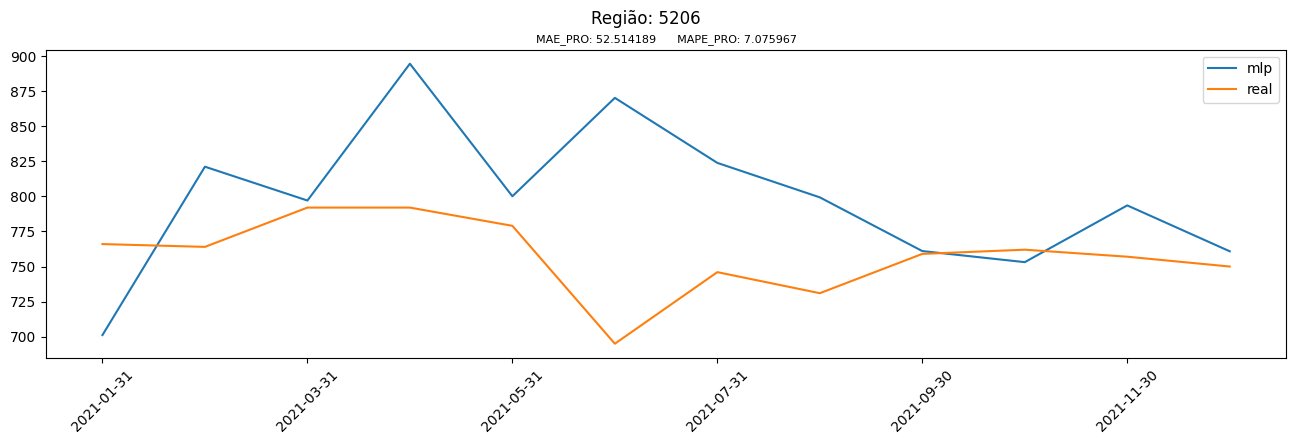

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-25-dc2c0bc79ff1>:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pred_results, ignore_index=True)


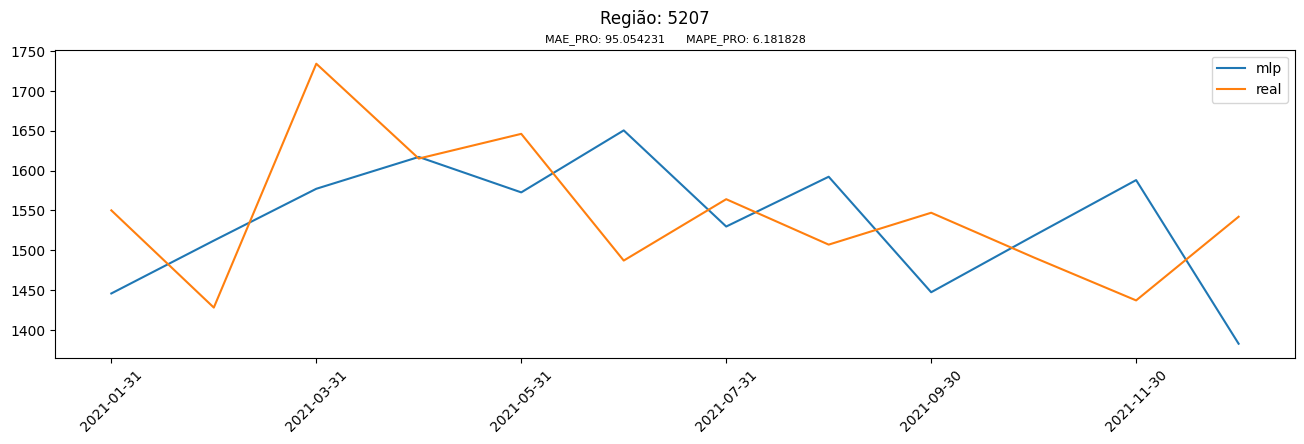

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-25-dc2c0bc79ff1>:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pred_results, ignore_index=True)


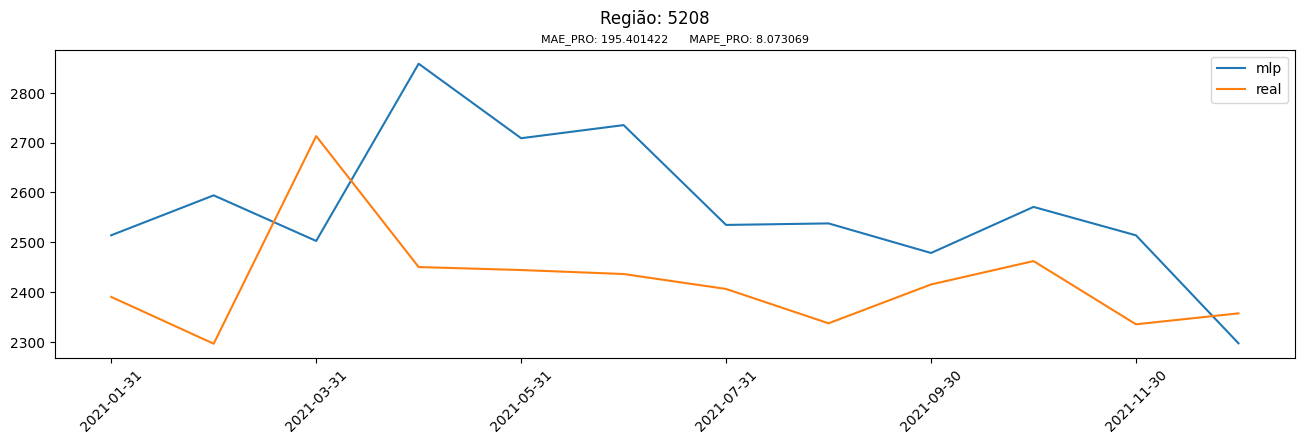

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-25-dc2c0bc79ff1>:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pred_results, ignore_index=True)


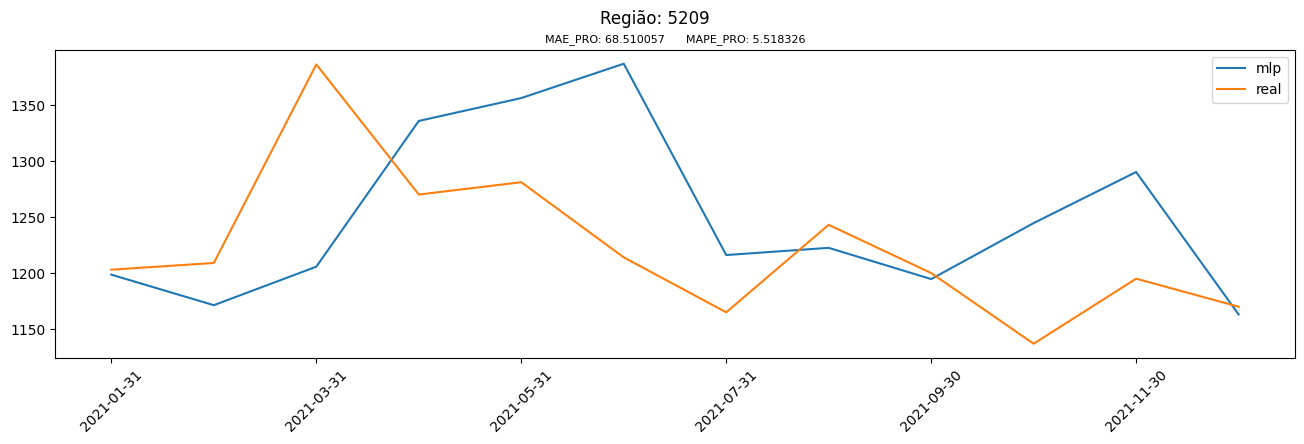

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-25-dc2c0bc79ff1>:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pred_results, ignore_index=True)


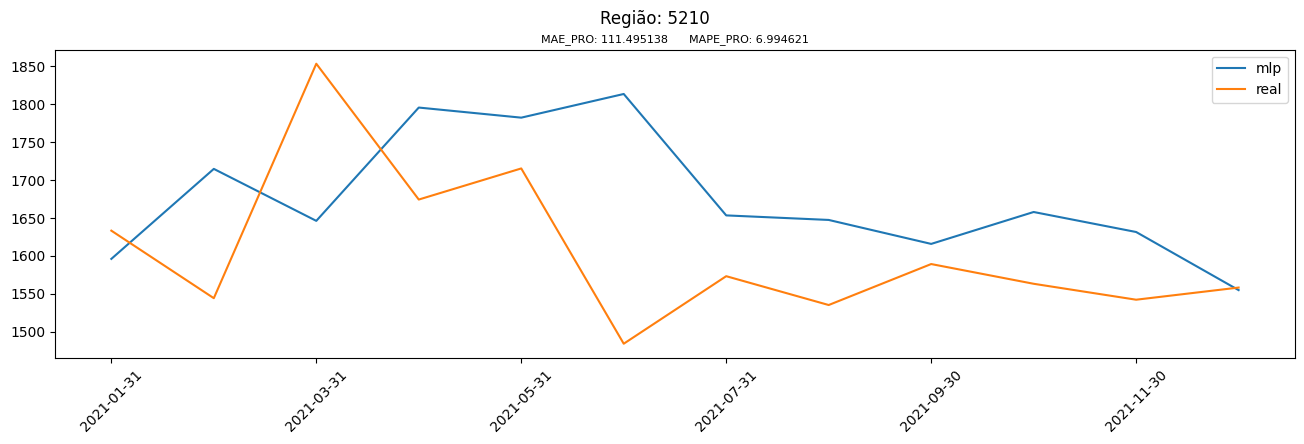

In [ ]:
experiment_name = 'co_optimization'
dest_data_path = os.path.join('/content/drive/Shareddrives/MS/case_nascidos/notebooks/macro_univariate/AdrielMori/results', experiment_name)
fig_path=dest_data_path+'/figures/'
samples= ['5206', '5207', '5208', '5209', '5210']
traintest_df, test_df, mape, mae, yhat_pro={}, {}, [], [], {}

for reg in samples:
    cfg = {'res': 'M',
            'dev_year': '2017-01-01',
            'test_year': '2021-01-01',
            'preds': 48,
            'path': os.path.join(data_path) + '/sinasc_macro_'+str(reg)+'_dia-mes-ano.csv',
          }
    data_path = r'/content/drive/Shareddrives/MS/case_nascidos/dataset/time_series/macro_regioes_v2/sinasc_macro_'+str(reg)+'_dia-mes-ano.csv'

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        _, _, traintest_df, test_df = get_dataset(data_path,
                                                  cfg['res'],
                                                  cfg['dev_year'],
                                                  cfg['test_year'])
        
        test_df=test_df.drop(test_df.index[[12, 13, 14, 15, 16, 17]])

    yhat_pro[reg]=pro(traintest_df, cfg['test_year'], cfg['preds']).values
    
    yhat_pro_print=yhat_pro[reg][:12]

    # Calculate Test metrics
    mae_mlp_val, mape_mlp_val = compute_errors(test_df['NASCIDOS'], yhat_pro_print)
    mape.append(mape_mlp_val)
    mae.append(mae_mlp_val)

    ## Crate yhat months for data
    initial_date, last_year= 0, 0
    initial_date = datetime.datetime.strptime(cfg['test_year'], '%Y-%d-%m')
    last_year = initial_date.year - 1

    dates = [(initial_date + relativedelta(months=i)).strftime('%m-%Y') 
                for i in range(cfg['preds'])]
    
    pred_results = {}
    pred_results['codibge'] = reg
    pred_results['mae_pro_2021'] = mae_mlp_val
    pred_results['mape_pro_2021'] = mape_mlp_val

    param_keys = list(pred_results.keys()).append('model')
    pred_results = get_pred_df(reg, 
                            'PROPHET', 
                            last_year+1,
                            int(int(cfg['preds'])/12), 
                            dict_base=pred_results)

    start_index = list(pred_results).index(f'jan-{last_year+1}')
    for i, value in enumerate(yhat_pro[reg].flatten()):
        pred_results[list(pred_results.keys())[start_index + i]] = value

    # cfg.update(pred_results)

    results_file=dest_data_path + f"/results_pro_2021-2024.csv"
    if os.path.exists(results_file):
        results = pd.read_csv(results_file)
    else:
        results = pd.DataFrame()

    results = results.append(pred_results, ignore_index=True)
    results.to_csv(results_file, index=False)

    plt.figure(figsize=(16,4))
    plt.plot(yhat_pro_print, label='mlp')
    plt.plot(test_df['DATA'].astype('str'), test_df['NASCIDOS'], label='real')
    plt.suptitle("Região: "+str(reg))
    plt.title("MAE_PRO: %f" % (mae_mlp_val)+"      MAPE_PRO: %f" % (mape_mlp_val), fontsize=8)
    plt.xticks(range(0, 12, 2), rotation=45)
    plt.legend()
    save_plot(fig_path+r'PROPHET_result_'+str(reg), 'png')
    plt.show()
    # break
    

In [ ]:
cont=0
for reg in samples:
    cfg = {'res': 'M',
            'dev_year': '2017-01-01',
            'test_year': '2021-01-01',
            'preds': 36
          }
    data_path = r'/content/drive/Shareddrives/MS/case_nascidos/dataset/time_series/macro_regioes_v2/sinasc_macro_'+str(reg)+'_dia-mes-ano.csv'

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        _, _, traintest_df, test_df = get_dataset(
            data_path, cfg['dev_year'], cfg['test_year'], res=cfg['res']
        )
        test_df=test_df.drop(test_df.index[[12, 13, 14, 15, 16, 17]])
    
    plt.figure(figsize=(16,4))
    plt.plot(yhat_pro[reg][:12], label='PROPHET')
    plt.plot(yhat_mlp[reg][:12], label='MLP')
    plt.plot(test_df['DATA'].astype('str'), test_df['NASCIDOS'], label='real')
    plt.suptitle("Região: "+str(reg), y=1.05, fontsize=17)
    plt.title("MAE_PRO: %f" % (mae[cont])+"      MAPE_PRO: %f" % (mape[cont]) +'\n'
            + "MAE_MLP: %f" % (mae_mlp[cont])+"      MAPE_MLP: %f" % (mape_mlp[cont]) , fontsize=8)
    plt.xticks(range(0, 12, 2), rotation=45)
    plt.legend()
    save_plot(fig_path+r'results_'+str(reg), 'png')
    plt.show()

    cont+=1